## The Warren Buffet Comparator function

In [1]:
def compare_with_buffett(strategy_returns, strategy_name="Our Strategy", initial_capital=100000, 
                         start_date=None, end_date=None, trading_dates=None, position_series=None):
    """
    Compare your trading strategy performance with Warren Buffett's approach (via Berkshire Hathaway).
    
    Parameters:
    -----------
    strategy_returns : Series or DataFrame
        A pandas Series containing the daily returns of your strategy. 
        If not specified, will use position_series to generate returns.
    strategy_name : str, default "Our Strategy"
        Name to display for your strategy in reports
    initial_capital : float, default 100000
        Initial investment amount
    start_date : datetime, optional
        Start date for comparison, if trading_dates not provided
    end_date : datetime, optional
        End date for comparison, if trading_dates not provided
    trading_dates : DatetimeIndex, optional
        Trading dates to use for comparison. If not provided, will use the index from strategy_returns
    position_series : Series, optional
        If provided, will use this series (containing -1, 0, 1 values) to calculate strategy returns
        from the asset's actual returns
        
    Returns:
    --------
    dict
        Dictionary containing performance metrics and DataFrames with results
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import yfinance as yf
    from IPython.display import display, HTML
    
    # Determine trading dates
    if trading_dates is None:
        if isinstance(strategy_returns, pd.Series) or isinstance(strategy_returns, pd.DataFrame):
            trading_dates = strategy_returns.index
        else:
            if start_date is None or end_date is None:
                raise ValueError("Must provide either trading_dates or start_date and end_date")
            # Create trading dates from start and end dates
            trading_dates = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # Download asset and Buffett data
    brk_b = yf.download('BRK-B', start=trading_dates[0], end=trading_dates[-1] + pd.DateOffset(days=1))
    brk_b = brk_b.reindex(trading_dates)
    brk_b['log_return'] = np.log(brk_b['Close']).diff().fillna(0)
    
    # Initialize results DataFrame
    results = pd.DataFrame(index=trading_dates)
    
    # Process strategy returns or position signals
    if position_series is not None:
        # We have position signals, so need asset price data
        asset_ticker = position_series.name if hasattr(position_series, 'name') else 'TSLA'
        asset_data = yf.download(asset_ticker, start=trading_dates[0], end=trading_dates[-1] + pd.DateOffset(days=1))
        asset_data = asset_data.reindex(trading_dates)
        asset_data['log_return'] = np.log(asset_data['Close']).diff().fillna(0)
        
        # Calculate strategy returns from positions
        results['position'] = position_series
        results['asset_return'] = asset_data['log_return']
        results['strategy_return'] = results['position'].shift(1) * results['asset_return']
        results['strategy_return'].iloc[0] = 0  # No return on first day
    else:
        # We already have strategy returns
        results['strategy_return'] = strategy_returns
    
    # Calculate cumulative returns and account balances
    results['strategy_cum_return'] = (1 + results['strategy_return']).cumprod() - 1
    results['strategy_balance'] = initial_capital * (1 + results['strategy_cum_return'])
    
    # Calculate Buffett's returns
    results['buffett_return'] = brk_b['log_return']
    results['buffett_cum_return'] = (1 + results['buffett_return']).cumprod() - 1
    results['buffett_balance'] = initial_capital * (1 + results['buffett_cum_return'])
    
    # Calculate buy & hold returns for the asset (if we have asset data)
    if 'asset_return' in results.columns:
        results['asset_cum_return'] = (1 + results['asset_return']).cumprod() - 1
        results['asset_balance'] = initial_capital * (1 + results['asset_cum_return'])
    
    # Calculate performance metrics
    days = len(results)
    annualization_factor = 252 / days
    
    # Function to calculate maximum drawdown
    def calculate_max_drawdown(returns):
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.cummax()
        drawdown = (cumulative / running_max) - 1
        return drawdown.min()
    
    # Strategy metrics
    strategy_annual_return = (1 + results['strategy_cum_return'].iloc[-1]) ** annualization_factor - 1
    strategy_sharpe = results['strategy_return'].mean() / results['strategy_return'].std() * np.sqrt(252)
    strategy_max_dd = calculate_max_drawdown(results['strategy_return'])
    strategy_volatility = results['strategy_return'].std() * np.sqrt(252)
    
    # Buffett metrics
    buffett_annual_return = (1 + results['buffett_cum_return'].iloc[-1]) ** annualization_factor - 1
    buffett_sharpe = results['buffett_return'].mean() / results['buffett_return'].std() * np.sqrt(252)
    buffett_max_dd = calculate_max_drawdown(results['buffett_return'])
    buffett_volatility = results['buffett_return'].std() * np.sqrt(252)
    
    # Asset metrics (if available)
    if 'asset_return' in results.columns:
        asset_name = asset_ticker if 'asset_ticker' in locals() else 'Asset'
        asset_annual_return = (1 + results['asset_cum_return'].iloc[-1]) ** annualization_factor - 1
        asset_sharpe = results['asset_return'].mean() / results['asset_return'].std() * np.sqrt(252)
        asset_max_dd = calculate_max_drawdown(results['asset_return'])
        asset_volatility = results['asset_return'].std() * np.sqrt(252)
    
    # Create performance summary table
    metrics = ['Total Return', 'Annual Return', 'Sharpe Ratio', 'Maximum Drawdown', 
               'Annual Volatility', 'Final Balance', 'Win Rate']
    
    summary_data = {
        'Metric': metrics,
        f'{strategy_name}': [
            f"{results['strategy_cum_return'].iloc[-1]:.2%}", 
            f"{strategy_annual_return:.2%}", 
            f"{strategy_sharpe:.2f}", 
            f"{strategy_max_dd:.2%}", 
            f"{strategy_volatility:.2%}",
            f"${results['strategy_balance'].iloc[-1]:,.2f}",
            f"{(results['strategy_return'] > 0).mean():.2%}"
        ],
        'Warren Buffett (BRK-B)': [
            f"{results['buffett_cum_return'].iloc[-1]:.2%}", 
            f"{buffett_annual_return:.2%}", 
            f"{buffett_sharpe:.2f}", 
            f"{buffett_max_dd:.2%}", 
            f"{buffett_volatility:.2%}",
            f"${results['buffett_balance'].iloc[-1]:,.2f}",
            f"{(results['buffett_return'] > 0).mean():.2%}"
        ]
    }
    
    if 'asset_return' in results.columns:
        summary_data[f'{asset_name} Buy & Hold'] = [
            f"{results['asset_cum_return'].iloc[-1]:.2%}", 
            f"{asset_annual_return:.2%}", 
            f"{asset_sharpe:.2f}", 
            f"{asset_max_dd:.2%}", 
            f"{asset_volatility:.2%}",
            f"${results['asset_balance'].iloc[-1]:,.2f}",
            f"{(results['asset_return'] > 0).mean():.2%}"
        ]
    
    summary_df = pd.DataFrame(summary_data)
    
    # Print and display performance summary
    print(f"\n===== {strategy_name} vs. Warren Buffett Performance Summary =====")
    display(HTML(summary_df.to_html(index=False, classes='table table-striped table-hover')))
    
    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['strategy_cum_return'] * 100, label=f'{strategy_name}', linewidth=2)
    plt.plot(results.index, results['buffett_cum_return'] * 100, label='Warren Buffett (BRK-B)', linewidth=2)
    if 'asset_return' in results.columns:
        plt.plot(results.index, results['asset_cum_return'] * 100, label=f'{asset_name} Buy & Hold', linewidth=2)
    plt.title('Cumulative Return Comparison (%)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return results for further analysis if needed
    output = {
        'results': results,
        'summary': summary_df,
        'metrics': {
            'strategy': {
                'annual_return': strategy_annual_return,
                'sharpe': strategy_sharpe,
                'max_drawdown': strategy_max_dd,
                'volatility': strategy_volatility,
                'final_balance': results['strategy_balance'].iloc[-1]
            },
            'buffett': {
                'annual_return': buffett_annual_return,
                'sharpe': buffett_sharpe,
                'max_drawdown': buffett_max_dd,
                'volatility': buffett_volatility,
                'final_balance': results['buffett_balance'].iloc[-1]
            }
        }
    }
    
    if 'asset_return' in results.columns:
        output['metrics']['asset'] = {
            'annual_return': asset_annual_return,
            'sharpe': asset_sharpe,
            'max_drawdown': asset_max_dd,
            'volatility': asset_volatility,
            'final_balance': results['asset_balance'].iloc[-1]
        }
    
    return output

## POSITION SIZES, FIXED AND TRAILING STOPLOSSES AND LEVERAGE

In [2]:
def remove_data_leakage(df, verbose=True):
    """
    Remove features that could cause data leakage in predictive models
    
    Parameters:
    -----------
    df : DataFrame
        The feature dataframe to clean
    verbose : bool, default=True
        Whether to print information about removed features
        
    Returns:
    --------
    DataFrame
        Cleaned dataframe with potential data leakage features removed
    """
    original_cols = df.columns.tolist()
    
    # Define patterns for features that likely cause data leakage
    leakage_patterns = [
        # Forward-looking market indicators
        'VIXCLS', 'SP500', 'ADS_Index', 'DCOILWTICO', 'DCOILBRENTEU',  
        
        # Same-day competitor returns
        '_Tech_Giants', '_Traditional_Auto', '_ETFs',
        
        # Return features that may include future information
        'Return_1D', 'Return_5D', 'Return_1M',
        
        # Same-day treasury/yield data
        'T10YIE', 'T5YIE', 'DGS10', 'T10Y3M', 'BAMLH0A0HYM2', 'AMERIBOR',
        
        # Features containing today's close price
        'close_open_ratio',  # Uses today's close
        'high_low_ratio',    # Uses today's high/low
        
        # Technical indicators calculated with today's close price
        'rsi', 'macd', 'bb_width', 'adx', 'cci',
        
        # Moving averages using today's prices
        'sma_20', 'sma_50', 'trend_strength',
    ]
    
    # Create a safe features list (basic features that definitely don't leak)
    safe_features = ['open', 'high', 'low', 'close', 'volume', 'log_return']
    
    # Columns to drop
    cols_to_drop = []
    for pattern in leakage_patterns:
        matching_cols = [col for col in df.columns if pattern in col]
        cols_to_drop.extend(matching_cols)
    
    # Remove duplicates
    cols_to_drop = list(set(cols_to_drop))
    
    # Keep safe features and make sure we're not dropping target variables
    for safe_feature in safe_features:
        if safe_feature in cols_to_drop and safe_feature in df.columns:
            cols_to_drop.remove(safe_feature)
    
    # Drop the identified columns
    clean_df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Add lagged versions of price and volume data for prediction
    if 'close' in clean_df.columns:
        for lag in [1, 2, 3, 5, 10, 21]:
            clean_df[f'close_lag_{lag}'] = clean_df['close'].shift(lag)
            if 'volume' in clean_df.columns:
                clean_df[f'volume_lag_{lag}'] = clean_df['volume'].shift(lag)
    
    # Calculate lagged returns (safe since they only use past data)
    if 'close' in clean_df.columns:
        clean_df['return_lag_1'] = clean_df['close'].pct_change(1).shift(1)
        clean_df['return_lag_5'] = clean_df['close'].pct_change(5).shift(1)
        clean_df['return_lag_10'] = clean_df['close'].pct_change(10).shift(1)
        clean_df['return_lag_21'] = clean_df['close'].pct_change(21).shift(1)
    
    # Calculate lagged volatility features
    if 'return_lag_1' in clean_df.columns:
        for window in [5, 10, 20]:
            clean_df[f'volatility_lag_{window}'] = clean_df['return_lag_1'].rolling(window).std().shift(1)
    
    if verbose:
        removed = len(cols_to_drop)
        remaining = len(clean_df.columns)
        print(f"Removed {removed} potentially leaking features out of {len(original_cols)}")
        print(f"Remaining features: {remaining}")
        print(f"Added historical lag features for prediction")
        
        if removed > 0 and verbose:
            print("\nRemoved features:")
            for i, col in enumerate(sorted(cols_to_drop)):
                print(f"  {i+1}. {col}")
    
    return clean_df

In [3]:
#ADVANCED CUSTOMISED FEATURES 
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def create_advanced_features(df):
    """Create advanced technical and market features"""
    # Price-based features
    df['log_return'] = np.log(df['close']).diff()
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']
    
    # Volume features
    df['volume_ma'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma']
    df['dollar_volume'] = df['close'] * df['volume']
    
    # Technical indicators
    df['rsi'] = ta.momentum.rsi(df['close'], window=14)
    df['rsi_30'] = ta.momentum.rsi(df['close'], window=30)
    df['macd'] = ta.trend.macd_diff(df['close'])
    df['bb_width'] = ta.volatility.bollinger_wband(df['close'])
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'])
    df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'])
    df['cci'] = ta.trend.cci(df['high'], df['low'], df['close'])
    
    # Trend indicators
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['trend_strength'] = (df['sma_20'] - df['sma_50']) / df['sma_50']
    
    # Market features
    df['vix_ratio'] = df['VIXCLS'] / df['VIXCLS'].rolling(10).mean()
    df['sp500_return'] = np.log(df['SP500']).diff()
    
    # Volatility features
    for window in [5, 10, 20, 30]:
        df[f'volatility_{window}'] = df['log_return'].rolling(window).std()
        df[f'momentum_{window}'] = df['log_return'].rolling(window).sum()
    
    # Risk management features
    df['trailing_max'] = df['close'].rolling(window=20).max()
    df['drawdown'] = (df['close'] / df['trailing_max']) - 1
    df['risk_ratio'] = df['atr'] / df['close']
    df['vix_percentile'] = df['VIXCLS'].rolling(252).apply(lambda x: stats.percentileofscore(x, x[-1]))
    
    return df

def calculate_position_size(prediction, confidence, volatility, vix_level, max_position=1.0):
    """
    Dynamically calculate position size based on prediction, confidence and market conditions
    
    Parameters:
    -----------
    prediction : float
        Predicted return
    confidence : float
        Statistical confidence in prediction (t-statistic)
    volatility : float
        Recent volatility of the asset
    vix_level : float
        Current VIX level as a percentile of its history
    max_position : float
        Maximum position size allowed
        
    Returns:
    --------
    float
        Position size between -max_position and max_position
    """
    # Base position from prediction sign and magnitude
    base_position = np.sign(prediction) * min(abs(prediction * 40), max_position)
    
    # Adjust for confidence
    confidence_factor = min(abs(confidence) / 1.5, 1.0)
    
    # Adjust for volatility (reduce position in high volatility)
    vol_factor = 1.0 - min(volatility * 5, 0.3)  
    
    # Adjust for VIX (reduce position when VIX is high)
    vix_factor = 1.0 - min(vix_level / 150, 0.3)
    
    # Combine all factors
    adjusted_position = base_position * confidence_factor * vol_factor * vix_factor
    
    # Ensure position is within bounds
    return np.clip(adjusted_position, -max_position, max_position)

def apply_stop_loss(positions, prices, initial_stop_pct=0.15, trailing_stop_pct=0.10):
    """
    Apply stop loss and trailing stop logic to positions
    
    Parameters:
    -----------
    positions : Series
        Raw position signals
    prices : Series
        Close prices
    initial_stop_pct : float
        Initial stop loss percentage
    trailing_stop_pct : float
        Trailing stop percentage
        
    Returns:
    --------
    Series
        Adjusted positions after applying stop loss logic
    """
    adjusted_positions = positions.copy()
    in_position = False
    entry_price = 0
    stop_price = 0
    position_type = 0  # 0=none, 1=long, -1=short
    
    for i in range(1, len(adjusted_positions)):
        curr_price = prices.iloc[i]
        prev_price = prices.iloc[i-1]
        
        # If we're not in a position and getting a new signal
        if not in_position and adjusted_positions.iloc[i] != 0:
            in_position = True
            entry_price = curr_price
            position_type = 1 if adjusted_positions.iloc[i] > 0 else -1
            
            # Set initial stop loss
            if position_type == 1:  # Long position
                stop_price = entry_price * (1 - initial_stop_pct)
            else:  # Short position
                stop_price = entry_price * (1 + initial_stop_pct)
        
        # If we're in a position
        elif in_position:
            # Check if stop loss was hit
            if (position_type == 1 and curr_price < stop_price) or \
               (position_type == -1 and curr_price > stop_price):
                # Stop loss hit - exit position
                adjusted_positions.iloc[i] = 0
                in_position = False
                position_type = 0
            
            # Update trailing stop if price moved favorably
            elif position_type == 1 and curr_price > prev_price:  # Long position
                new_stop = curr_price * (1 - trailing_stop_pct)
                if new_stop > stop_price:
                    stop_price = new_stop
            
            elif position_type == -1 and curr_price < prev_price:  # Short position
                new_stop = curr_price * (1 + trailing_stop_pct)
                if new_stop < stop_price or stop_price == 0:
                    stop_price = new_stop
            
            # Check if position direction changed in signal
            if (position_type == 1 and adjusted_positions.iloc[i] < 0) or \
               (position_type == -1 and adjusted_positions.iloc[i] > 0):
                # Exit old position and enter new one
                in_position = True
                entry_price = curr_price
                position_type = 1 if adjusted_positions.iloc[i] > 0 else -1
                
                # Reset stop loss for new position
                if position_type == 1:  # Long position
                    stop_price = entry_price * (1 - initial_stop_pct)
                else:  # Short position
                    stop_price = entry_price * (1 + initial_stop_pct)
            
            # If signal goes to zero, exit position
            elif adjusted_positions.iloc[i] == 0:
                in_position = False
                position_type = 0
    
    return adjusted_positions


def position_sizing_and_risk_management(df, predictions, model, X_pca, max_risk_per_trade=0.05):
    """
    Implement position sizing and risk management strategy
    
    Parameters:
    -----------
    df : DataFrame
        Dataset with prices and features
    predictions : Series
        Model predictions
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        Trained OLS model
    X_pca : DataFrame
        PCA-transformed features used for prediction
    max_risk_per_trade : float
        Maximum risk per trade as fraction of capital
        
    Returns:
    --------
    DataFrame
        DataFrame with position signals and risk metrics
    """
    # Create position DataFrame
    positions_df = pd.DataFrame(index=predictions.index)
    positions_df['prediction'] = predictions
    
    # Calculate standard error for each prediction
    X_with_const = sm.add_constant(X_pca.loc[predictions.index])
    prediction_stats = model.get_prediction(X_with_const)
    positions_df['prediction_std'] = prediction_stats.summary_frame()['mean_se']
    
    # Calculate t-statistic for confidence
    positions_df['t_stat'] = positions_df['prediction'] / positions_df['prediction_std']
    
    # Get market conditions
    positions_df['volatility'] = df.loc[predictions.index, 'volatility_20']
    positions_df['vix_percentile'] = df.loc[predictions.index, 'vix_percentile']
    
    # Calculate position sizes based on prediction, confidence and market conditions
    positions_df['raw_position'] = positions_df.apply(
        lambda x: calculate_position_size(
            x['prediction'], 
            x['t_stat'], 
            x['volatility'],
            x['vix_percentile']
        ), 
        axis=1
    )
    
    # Apply stop loss and trailing stop logic
    positions_df['position'] = apply_stop_loss(
        positions_df['raw_position'],
        df.loc[predictions.index, 'close'],
        initial_stop_pct=0.30,
        trailing_stop_pct=0.10
    )
    
    # Calculate position size based on risk (ATR)
    positions_df['atr'] = df.loc[predictions.index, 'atr']
    positions_df['close'] = df.loc[predictions.index, 'close']
    positions_df['risk_factor'] = positions_df['atr'] / positions_df['close']
    
    # Calculate risk-adjusted position size (for fixed % of capital at risk)
    # If ATR is 5% of price and max risk is 2%, position size should be 0.4 (2% ÷ 5%)
    positions_df['risk_adjusted_size'] = np.where(
        positions_df['risk_factor'] > 0,
        max_risk_per_trade / positions_df['risk_factor'],
        1.0
    )
    
    # Final position is direction from model * size from risk model, capped at original magnitude
    positions_df['final_position'] = np.sign(positions_df['position']) * np.minimum(
        abs(positions_df['position']),
        positions_df['risk_adjusted_size']
    )
    


    # Apply conditional leverage based on trend direction and momentum
    positions_df['market_trend'] = np.sign(df.loc[predictions.index, 'sma_20'] - df.loc[predictions.index, 'sma_50'])
    positions_df['momentum'] = df.loc[predictions.index, 'momentum_20']

    # Apply more leverage when trend and prediction align
    leverage_factor = np.where(
        (positions_df['market_trend'] * np.sign(positions_df['final_position']) > 0) & 
        (np.abs(positions_df['momentum']) > 0.02),
        1.8,  # Higher leverage when trend confirms prediction
        1.0   # Normal leverage otherwise
    )

    positions_df['final_position'] = positions_df['final_position'] * leverage_factor
    positions_df['final_position'] = np.clip(positions_df['final_position'], -1.0, 1.0)
    
    # Add buy/sell/hold signals for visualization
    positions_df['signal'] = 0
    positions_df.loc[positions_df['final_position'] > 0.02, 'signal'] = 1
    positions_df.loc[positions_df['final_position'] < -0.02, 'signal'] = -1
    
    return positions_df


## Using LASSO for feature selection 

Competitor data loaded successfully.
Added 22 competitor features.
NaNs in X: 0
NaNs in y: 0
Total features: 99
Optimal alpha: 0.000357289309082749

LASSO selected 9 out of 99 features

Features Selected by LASSO:
                    Feature  Coefficient
13                Return_1D     0.039208
66               momentum_5     0.001340
64             sp500_return     0.000971
74                 drawdown     0.000498
22                      HML    -0.000355
89         AAPL_Tech_Giants     0.000340
48           high_low_ratio    -0.000142
26                ADS_Index    -0.000108
86  BMW.DE_Traditional_Auto     0.000024

OLS Model with LASSO-selected features:
                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     5417.
Date:              

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


===== LASSO Feature-Based Strategy vs. Warren Buffett Performance Summary =====


Metric,LASSO Feature-Based Strategy,Warren Buffett (BRK-B),TSLA Buy & Hold
Total Return,30.07%,77.01%,115.67%
Annual Return,7.17%,16.23%,22.43%
Sharpe Ratio,0.38,0.75,0.67
Maximum Drawdown,-41.64%,-27.59%,-79.64%
Annual Volatility,35.93%,24.14%,76.01%
Final Balance,"$130,070.43","$177,011.37","$215,673.91"
Win Rate,49.43%,53.29%,52.56%


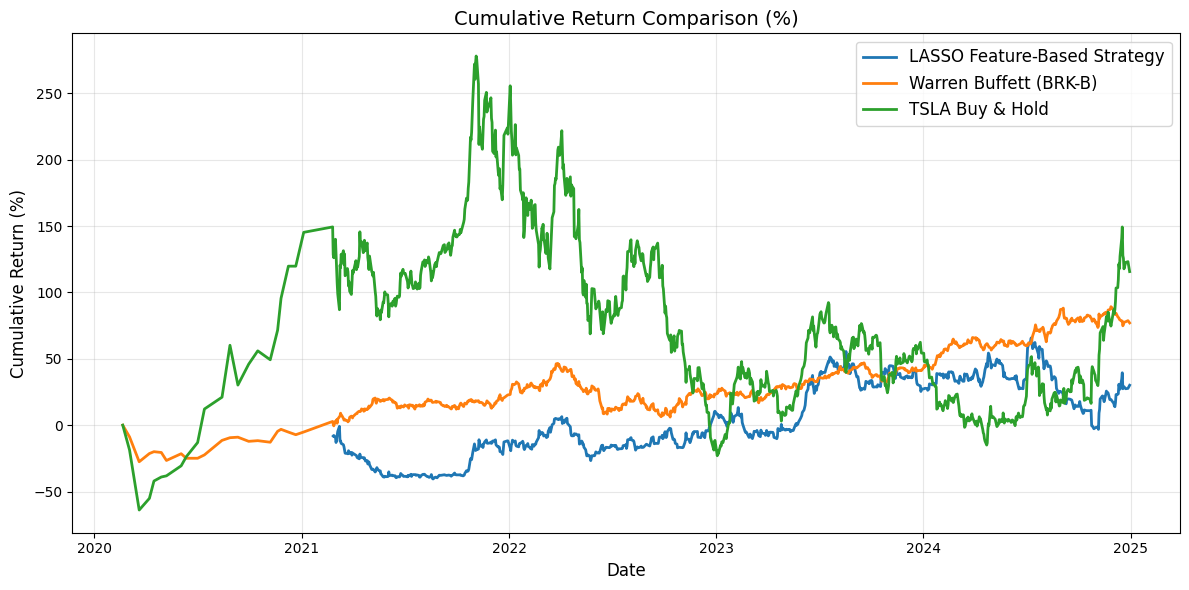

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Load your Tesla feature mart
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create your features and target
df = create_advanced_features(df)  # Your existing function
y = df['log_return'].copy()

# Load competitor data
try:
    competitor_returns = pd.read_csv('tesla_competitors.csv', index_col=0)
    competitor_returns.index = pd.to_datetime(competitor_returns.index)
    use_competitors = True
    print("Competitor data loaded successfully.")
except:
    print("Competitor data not found. Proceeding without competitor features.")
    use_competitors = False

# Prepare features
X = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1)

# Merge with competitor returns if available
if use_competitors:
    X = pd.concat([X, competitor_returns], axis=1)
    print(f"Added {competitor_returns.shape[1]} competitor features.")

# Clean data
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(method='ffill').fillna(method='bfill')
y = y.fillna(method='ffill').fillna(method='bfill')

# Make sure X and y are aligned
common_idx = X.index.intersection(y.index)
X = X.loc[common_idx]
y = y.loc[common_idx]

# Drop any remaining NaN values
mask = ~(np.isnan(y) | X.isna().any(axis=1))
X = X.loc[mask]
y = y.loc[mask]

# Check that there are no NaN values left
print(f"NaNs in X: {X.isna().sum().sum()}")
print(f"NaNs in y: {y.isna().sum()}")
print(f"Total features: {X.shape[1]}")

# Standardize features (important for LASSO)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Find optimal alpha using cross-validation
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_scaled, y)
optimal_alpha = lasso_cv.alpha_

print(f"Optimal alpha: {optimal_alpha}")

# Run LASSO with optimal alpha
lasso_model = Lasso(alpha=optimal_alpha, fit_intercept=True, max_iter=10000)
lasso_model.fit(X_scaled, y)

# Create DataFrame with feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
})

# Filter only non-zero coefficients (selected features)
selected_features = feature_importance[feature_importance['Coefficient'] != 0].sort_values(
    by='Coefficient', key=abs, ascending=False
)

print(f"\nLASSO selected {len(selected_features)} out of {X.shape[1]} features")

# Display selected features
print("\nFeatures Selected by LASSO:")
print(selected_features)

# Test these features in an OLS model
X_top = X[selected_features['Feature']]
X_top = sm.add_constant(X_top)
model = sm.OLS(y, X_top).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
print("\nOLS Model with LASSO-selected features:")
print(model.summary())

# Calculate correlation of predictions with actual returns
y_pred = model.predict(X_top)
correlation = np.corrcoef(y, y_pred)[0, 1]
print(f"\nCorrelation between actual and predicted returns: {correlation:.4f}")

# Implement LASSO-based trading strategy
def lasso_feature_trading_strategy(df, selected_features):
    """
    Implement a trading strategy using LASSO-selected features
    """
    print("\nLASSO Feature-Based Trading Model")
    print("-" * 50)
    
    # Create advanced features
    df = create_advanced_features(df)
    
    # Load competitor data
    try:
        competitor_returns = pd.read_csv('tesla_competitors.csv', index_col=0)
        competitor_returns.index = pd.to_datetime(competitor_returns.index)
        use_competitors = True
    except:
        print("Competitor data not found. Proceeding without competitor features.")
        use_competitors = False
    
    # Prepare features and target
    y = df['log_return'].copy()
    X = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1)
    
    # Merge with competitor returns if available
    if use_competitors:
        X = pd.concat([X, competitor_returns], axis=1)
    
    # Clean data
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(method='ffill').fillna(method='bfill')
    y = y.fillna(method='ffill').fillna(method='bfill')
    
    # Keep only selected features
    feature_list = selected_features['Feature'].tolist()
    available_features = [f for f in feature_list if f in X.columns]
    X_selected = X[available_features]
    
    # Ensure data alignment
    common_idx = y.index.intersection(X_selected.index)
    y = y.loc[common_idx]
    X_selected = X_selected.loc[common_idx]
    
    # Sort by date
    y = y.sort_index()
    X_selected = X_selected.sort_index()
    
    # Remove any remaining NaN values
    mask = ~(y.isna() | X_selected.isna().any(axis=1))
    y = y[mask]
    X_selected = X_selected[mask]
    df_clean = df.loc[y.index]
    
    # Time-based train-test split (80% train, 20% test)
    train_size = int(len(X_selected) * 0.8)
    X_train = X_selected.iloc[:train_size]
    X_test = X_selected.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    
    # Fit model on training data
    X_train_const = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_const).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    
    # Predict on all data for position sizing
    X_all_const = sm.add_constant(X_selected)
    all_predictions = model.predict(X_all_const)
    
    # Apply position sizing and risk management (using the same risk model as the PCA strategy)
    positions_df = position_sizing_and_risk_management(
        df_clean, all_predictions, model, X_selected, max_risk_per_trade=0.03
    )
    
    # Final positions for trading
    final_positions = positions_df['final_position']
    final_positions.name = 'TSLA'  # Name for Warren Buffett comparison
    
    return model, final_positions, y

# Run the LASSO feature-based trading strategy and compare with Warren Buffett
lasso_model, lasso_positions, lasso_y = lasso_feature_trading_strategy(df, selected_features)

# Calculate strategy returns
lasso_strategy_returns = lasso_positions.shift(1) * lasso_y
lasso_strategy_returns = lasso_strategy_returns.dropna()

# Compare with Warren Buffett
lasso_comparison = compare_with_buffett(
    strategy_returns=lasso_strategy_returns,
    strategy_name="LASSO Feature-Based Strategy",
    initial_capital=100000,
    position_series=lasso_positions
)

## Feature selection using Random forest 

Competitor data loaded successfully.
Added 22 competitor features.
Total features: 99
Total observations: 1187

Top 20 Features Selected by Random Forest:
                  Feature  Importance
13              Return_1D    0.183166
49       close_open_ratio    0.092954
95               XLY_ETFs    0.076756
9              BBP_10_2.0    0.046514
96              ARKK_ETFs    0.043628
97              DRIV_ETFs    0.039763
98              IDRV_ETFs    0.038879
20                 Mkt-RF    0.024480
74               drawdown    0.023138
77          NIO_EV_makers    0.021375
66             momentum_5    0.019463
90       NVDA_Tech_Giants    0.018985
48         high_low_ratio    0.017919
64           sp500_return    0.017524
89       AAPL_Tech_Giants    0.017354
14              Return_5D    0.016661
51           volume_ratio    0.016653
65           volatility_5    0.014906
88  RACE_Traditional_Auto    0.012780
91        AMD_Tech_Giants    0.011406


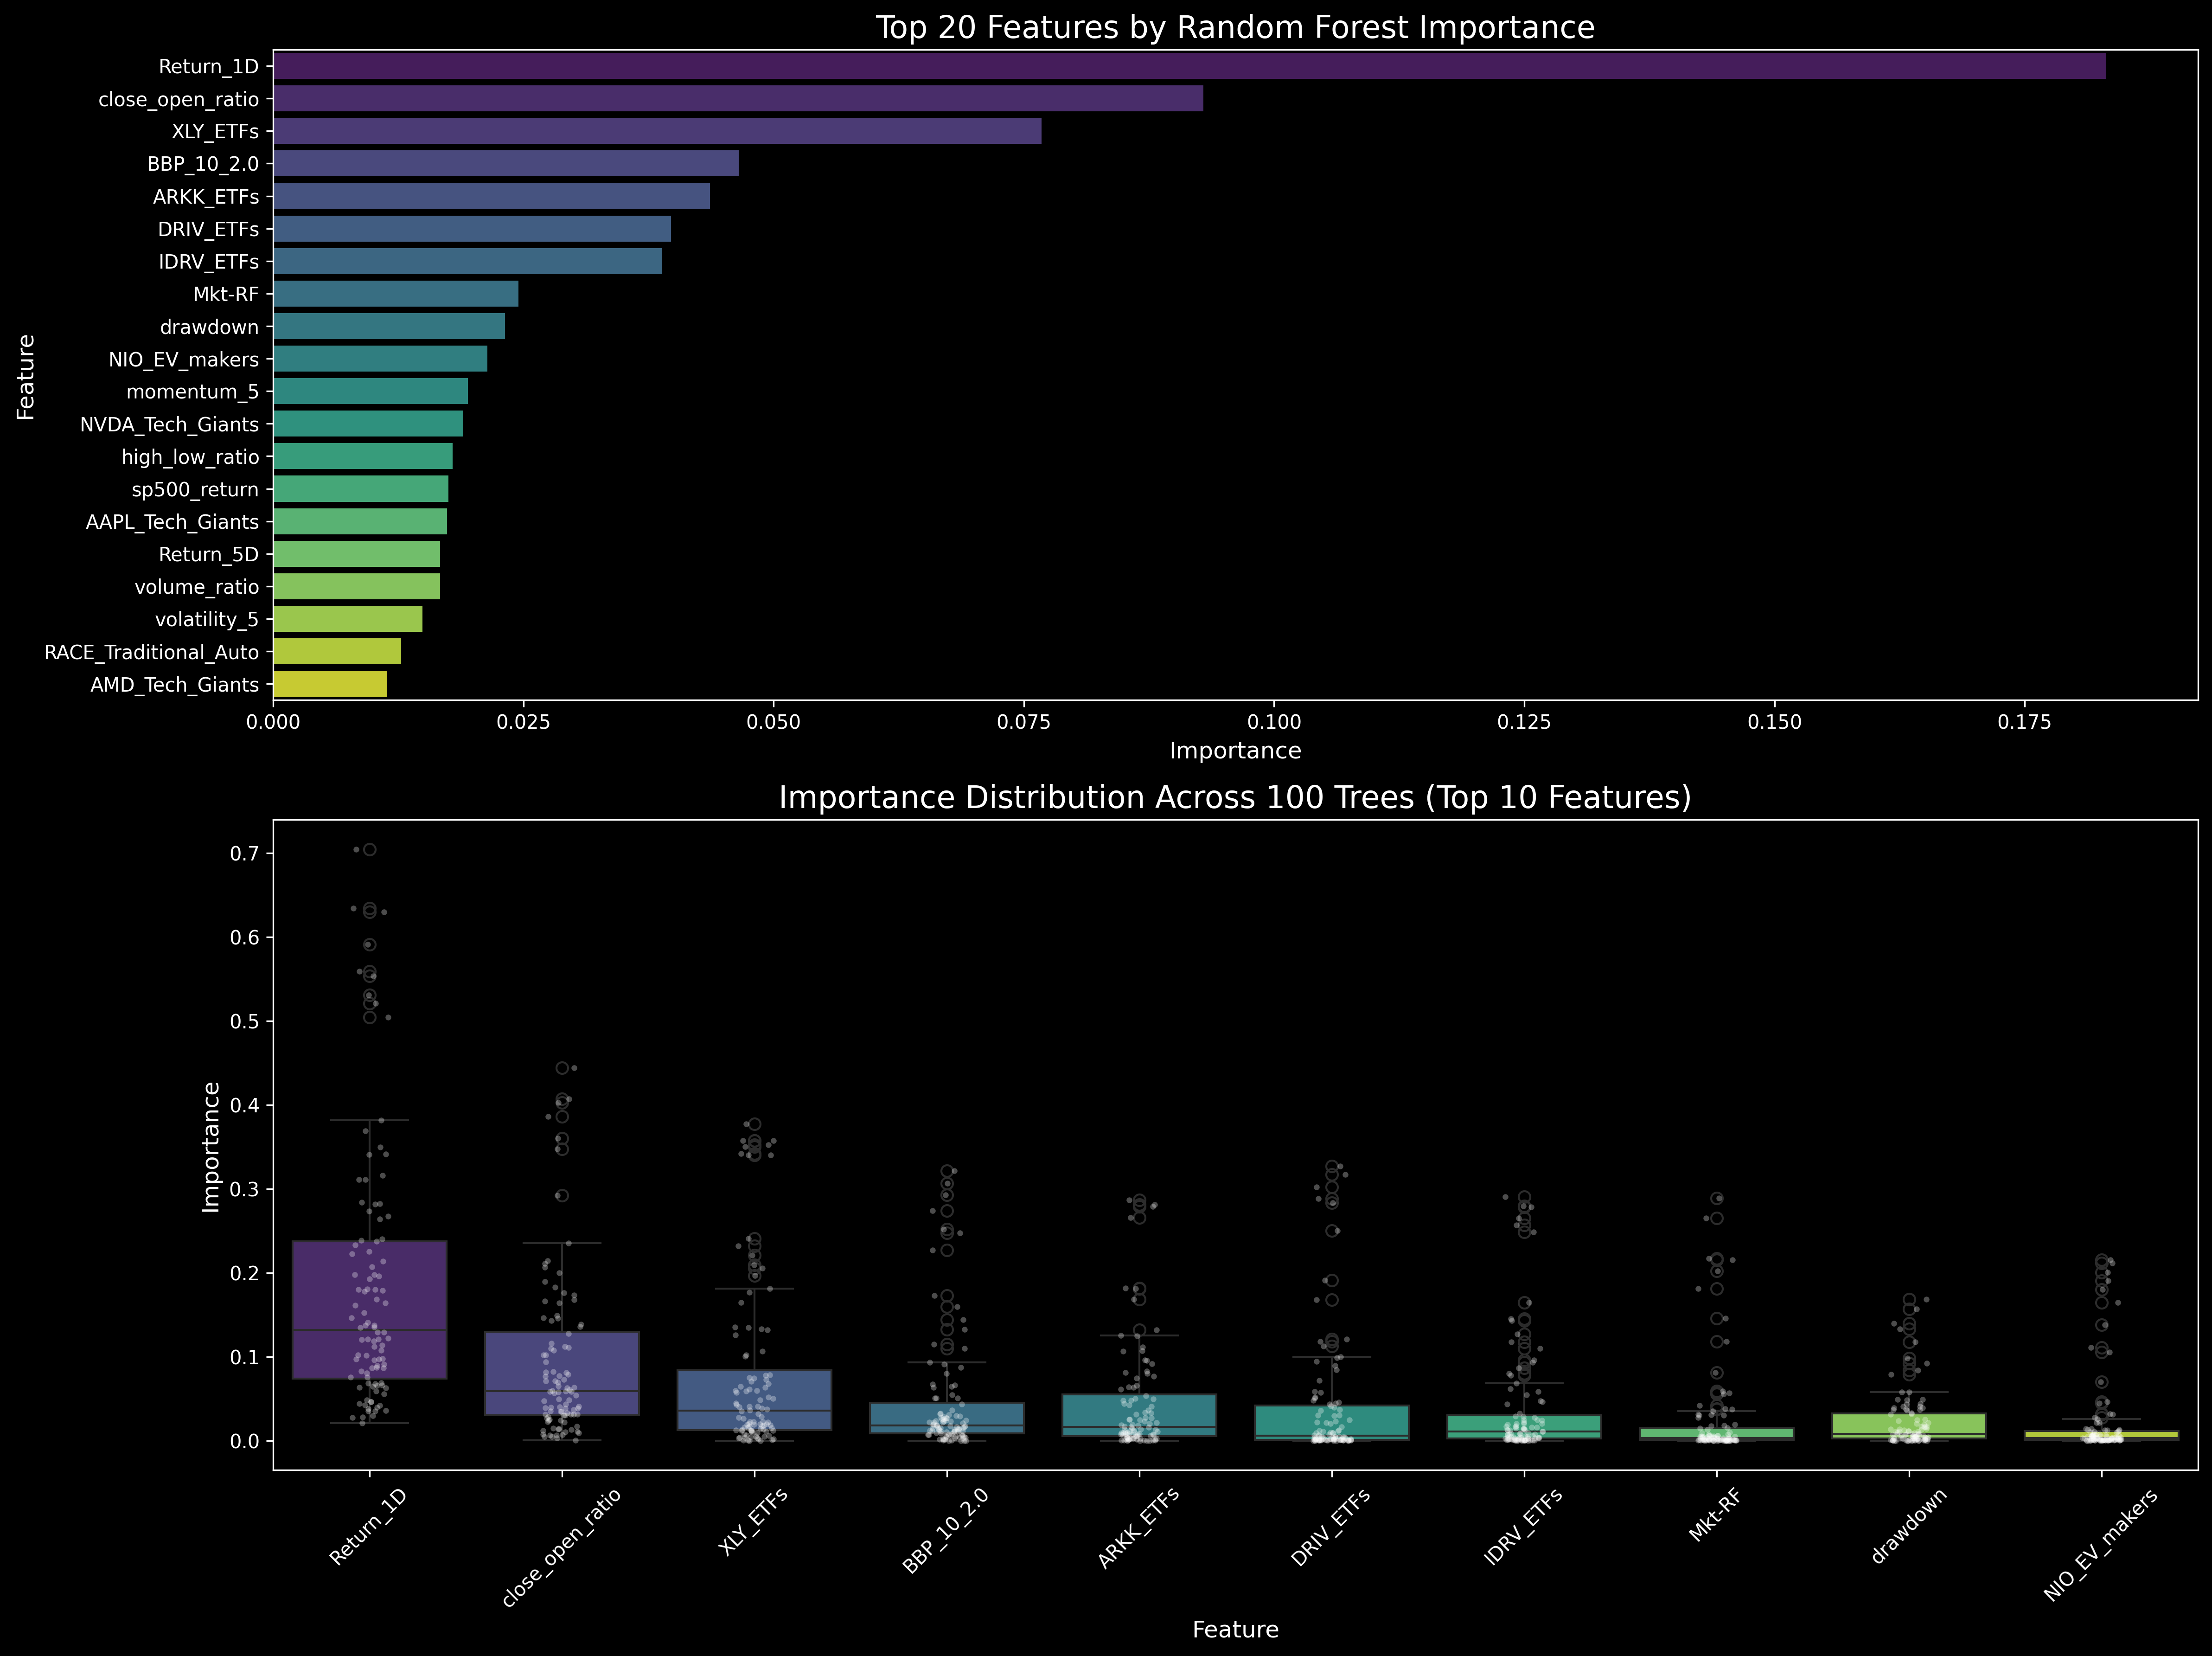


Features for your trading model:
['Return_1D', 'close_open_ratio', 'XLY_ETFs', 'BBP_10_2.0', 'ARKK_ETFs', 'DRIV_ETFs', 'IDRV_ETFs', 'Mkt-RF', 'drawdown', 'NIO_EV_makers', 'momentum_5', 'NVDA_Tech_Giants', 'high_low_ratio', 'sp500_return', 'AAPL_Tech_Giants', 'Return_5D', 'volume_ratio', 'volatility_5', 'RACE_Traditional_Auto', 'AMD_Tech_Giants']


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Set dark mode for visualizations
plt.style.use('dark_background')

# Load data and create features
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create advanced features using your existing function
df = create_advanced_features(df)

# Prepare target variable
y = df['log_return'].copy()

# Load competitor data if available
try:
    competitor_returns = pd.read_csv('tesla_competitors.csv', index_col=0)
    competitor_returns.index = pd.to_datetime(competitor_returns.index)
    use_competitors = True
    print("Competitor data loaded successfully.")
except:
    print("Competitor data not found. Proceeding without competitor features.")
    use_competitors = False

# Prepare features
X = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1)

# Merge with competitor returns if available
if use_competitors:
    X = pd.concat([X, competitor_returns], axis=1)
    print(f"Added {competitor_returns.shape[1]} competitor features.")

# Clean data
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(method='ffill').fillna(method='bfill')
y = y.fillna(method='ffill').fillna(method='bfill')

# Make sure X and y are aligned
common_idx = X.index.intersection(y.index)
X = X.loc[common_idx]
y = y.loc[common_idx]

# Drop any remaining NaN values
mask = ~(np.isnan(y) | X.isna().any(axis=1))
X = X.loc[mask]
y = y.loc[mask]

print(f"Total features: {X.shape[1]}")
print(f"Total observations: {X.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Define the Random Forest model with optimal parameters
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model
model.fit(X_scaled, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', key=abs, ascending=False)

# Display top 20 features
top_features = feature_importance.head(20)
print("\nTop 20 Features Selected by Random Forest:")
print(top_features)

# Create a multi-level visualization of feature importance
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), dpi=300)

# Top features bar chart
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_features,
    palette='viridis',
    ax=axes[0]
)
axes[0].set_title('Top 20 Features by Random Forest Importance', fontsize=16)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)
axes[0].tick_params(axis='y', labelsize=10)

# Detailed importance distribution for top 10 features
df_feature_all = pd.DataFrame(
    [tree.feature_importances_ for tree in model.estimators_], 
    columns=X.columns
)
df_top10 = df_feature_all[top_features['Feature'].head(10)]
df_feature_long = pd.melt(df_top10, var_name='Feature', value_name='Importance')

sns.boxplot(
    x='Feature', 
    y='Importance', 
    data=df_feature_long,
    palette='viridis',
    ax=axes[1]
)
sns.stripplot(
    x='Feature', 
    y='Importance', 
    data=df_feature_long,
    color='white',
    alpha=0.3,
    size=3,
    ax=axes[1]
)
axes[1].set_title('Importance Distribution Across 100 Trees (Top 10 Features)', fontsize=16)
axes[1].set_xlabel('Feature', fontsize=12)
axes[1].set_ylabel('Importance', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.show()

# Export top features list for easy use in your model
top_features_list = top_features['Feature'].tolist()
print("\nFeatures for your trading model:")
print(top_features_list)

## Model 1 Random Forest Regressor

In [38]:
import math

def rf_trading_strategy(df):
    """
    Random Forest-based trading strategy using selected features
    """
    print("\nRandom Forest Trading Model")
    print("-" * 50)
    
    # Create advanced features
    df = create_advanced_features(df)
    
    # Load competitor data
    try:
        competitor_returns = pd.read_csv('tesla_competitors.csv', index_col=0)
        competitor_returns.index = pd.to_datetime(competitor_returns.index)
        use_competitors = True
    except:
        print("Competitor data not found. Proceeding without competitor features.")
        use_competitors = False
    
    # Prepare features and target
    y = df['log_return'].copy()
    X = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1)
    
    # Merge with competitor returns if available
    if use_competitors:
        X = pd.concat([X, competitor_returns], axis=1)
    
    # Clean data
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(method='ffill').fillna(method='bfill')
    y = y.fillna(method='ffill').fillna(method='bfill')
    
    # Keep only selected features
    available_features = [f for f in top_features if f in X.columns]
    X_selected = X[available_features]
    
    # Ensure data alignment
    common_idx = y.index.intersection(X_selected.index)
    y = y.loc[common_idx]
    X_selected = X_selected.loc[common_idx]
    
    # Sort by date
    y = y.sort_index()
    X_selected = X_selected.sort_index()
    
    # Remove any remaining NaN values
    mask = ~(y.isna() | X_selected.isna().any(axis=1))
    y = y[mask]
    X_selected = X_selected[mask]
    df_clean = df.loc[y.index]
    
    # Time-based train-test split (80% train, 20% test)
    train_size = int(len(X_selected) * 0.8)
    X_train = X_selected.iloc[:train_size]
    X_test = X_selected.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    
    # Record the split date for later use
    split_date = y.index[train_size]
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define and train the Random Forest model with optimal hyperparameters
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_leaf=4,
        min_samples_split=10,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Predictions and evaluation
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Calculate RMSE
    train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
    
    print(f"Training RMSE: {train_rmse:.6f}")
    print(f"Testing RMSE: {test_rmse:.6f}")
    
    # Generate predictions for trading
    X_all_scaled = scaler.transform(X_selected)
    all_predictions = model.predict(X_all_scaled)
    
    # Statistical information about predictions (for use in position sizing)
    prediction_std = np.zeros(len(all_predictions))
    
    # Estimate prediction variance using a rolling window approach
    window_size = 20
    for i in range(window_size, len(all_predictions)):
        pred_window = all_predictions[i-window_size:i]
        prediction_std[i] = np.std(pred_window)
    
    # Fill the first values with the overall standard deviation
    prediction_std[:window_size] = np.std(all_predictions[:window_size])
    
    # Create a dataframe for model stats to pass to position sizing
    model_stats = pd.DataFrame({
        'prediction': all_predictions,
        'prediction_std': prediction_std
    }, index=X_selected.index)
    
    # Apply position sizing and risk management
    positions_df = rf_position_sizing(
        df_clean, 
        model_stats, 
        X_selected, 
        max_risk_per_trade=0.03
    )
    
    # Final positions for trading
    final_positions = positions_df['final_position']
    final_positions.name = 'TSLA'
    
    # Calculate strategy returns - don't drop NaNs yet
    raw_strategy_returns = final_positions.shift(1) * y
    
    # Create a copy for performance calculations
    strategy_returns = raw_strategy_returns.copy()
    
    # Calculate cumulative returns - use all data including NaNs (filled with zeros)
    cum_strategy = (1 + strategy_returns.fillna(0)).cumprod()
    cum_asset = (1 + y.fillna(0)).cumprod()
    
    # Calculate risk-adjusted performance metrics
    # Only now we can drop NaNs for calculation of statistics
    strategy_returns_clean = strategy_returns.dropna()
    annualized_return = (cum_strategy.iloc[-1] ** (252 / len(cum_strategy))) - 1
    annualized_volatility = strategy_returns_clean.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0
    
    # Calculate maximum drawdown
    rolling_max = cum_strategy.cummax()
    drawdown = (cum_strategy / rolling_max) - 1
    max_drawdown = drawdown.min()
    
    # Calculate out-of-sample performance using the date index
    # First keep the index aligned 
    test_returns = strategy_returns[y.index >= split_date].fillna(0)
    
    if len(test_returns) > 0:
        out_cum_return = (1 + test_returns).cumprod().iloc[-1] - 1
        out_ann_return = (1 + out_cum_return) ** (252 / len(test_returns)) - 1
        out_ann_vol = test_returns.std() * np.sqrt(252)
        out_sharpe = out_ann_return / out_ann_vol if out_ann_vol > 0 else 0
    else:
        out_cum_return = 0
        out_ann_return = 0
        out_ann_vol = 0
        out_sharpe = 0
    
    # Print performance metrics
    print("\nTrading Strategy Performance:")
    print("-" * 50)
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Win Rate: {(strategy_returns_clean > 0).mean():.2%}")
    
    print("\nOut-of-Sample Performance:")
    print("-" * 50)
    print(f"OOS Return: {out_cum_return:.2%}")
    print(f"OOS Annualized Return: {out_ann_return:.2%}")
    print(f"OOS Sharpe Ratio: {out_sharpe:.2f}")
    
    # Visualizations
    plt.figure(figsize=(12, 6))
    plt.plot(cum_strategy, label='RF Strategy', color='cyan', linewidth=2)
    plt.plot(cum_asset, label='TSLA Buy & Hold', color='magenta', linewidth=2)
    plt.axvline(x=split_date, color='white', linestyle='--', alpha=0.7)
    plt.text(split_date, plt.gca().get_ylim()[1]*0.9, ' Test Set', verticalalignment='center')
    plt.title('Random Forest Model: Cumulative Returns', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    # Return the original series with NaNs for comparison function
    return model, final_positions, raw_strategy_returns, y

def rf_position_sizing(df, model_stats, X, max_risk_per_trade=0.05):
    """Custom position sizing for Random Forest model"""
    positions_df = pd.DataFrame(index=model_stats.index)
    positions_df['prediction'] = model_stats['prediction']
    positions_df['prediction_std'] = model_stats['prediction_std']
    
    # Create t-statistic for confidence 
    positions_df['t_stat'] = positions_df['prediction'] / positions_df['prediction_std']
    
    # Get market conditions
    positions_df['volatility'] = df.loc[positions_df.index, 'volatility_20']
    positions_df['vix_percentile'] = df.loc[positions_df.index, 'vix_percentile']
    
    # Calculate position sizes
    positions_df['raw_position'] = positions_df.apply(
        lambda x: calculate_position_size(
            x['prediction'], 
            x['t_stat'], 
            x['volatility'],
            x['vix_percentile']
        ), 
        axis=1
    )
    # Apply stop loss logic
    positions_df['position'] = apply_stop_loss(
        positions_df['raw_position'],
        df.loc[positions_df.index, 'close'],
        initial_stop_pct=0.25,
        trailing_stop_pct=0.08
    )
    
    # Apply risk-based position sizing
    positions_df['atr'] = df.loc[positions_df.index, 'atr']
    positions_df['close'] = df.loc[positions_df.index, 'close']
    positions_df['risk_factor'] = positions_df['atr'] / positions_df['close']
    
    positions_df['risk_adjusted_size'] = np.where(
        positions_df['risk_factor'] > 0,
        max_risk_per_trade / positions_df['risk_factor'],
        1.0
    )
    
    # Final position 
    positions_df['final_position'] = np.sign(positions_df['position']) * np.minimum(
        abs(positions_df['position']),
        positions_df['risk_adjusted_size']
    )

    # Apply conditional leverage
    positions_df['market_trend'] = np.sign(df.loc[positions_df.index, 'sma_20'] - df.loc[positions_df.index, 'sma_50'])
    positions_df['momentum'] = df.loc[positions_df.index, 'momentum_20']
    
    leverage_factor = np.where(
        (positions_df['market_trend'] * np.sign(positions_df['final_position']) > 0) & 
        (np.abs(positions_df['momentum']) > 0.02),
        1.5,  # Lower leverage than PCA model
        1.0 
    )
    
    positions_df['final_position'] = positions_df['final_position'] * leverage_factor
    positions_df['final_position'] = np.clip(positions_df['final_position'], -1.0, 1.0)
    
    # Add signals for visualization
    positions_df['signal'] = 0
    positions_df.loc[positions_df['final_position'] > 0.02, 'signal'] = 1
    positions_df.loc[positions_df['final_position'] < -0.02, 'signal'] = -1
    
    return positions_df

# Load data
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Run Random Forest trading strategy
rf_model, rf_positions, rf_strategy_returns, rf_y = rf_trading_strategy(df)

# Compare with Warren Buffett
rf_comparison = compare_with_buffett(
    strategy_returns=rf_strategy_returns,
    strategy_name="Random Forest Strategy",
    initial_capital=100000,
    position_series=rf_positions
)
    


Random Forest Trading Model
--------------------------------------------------


ValueError: at least one array or dtype is required

Bagging Regressor Model


📊 Bagging Regressor Metrics:
R² Test: 0.5187
RMSE Test: 0.0278
Sharpe Ratio: 0.1304
Max Drawdown: -39.35%


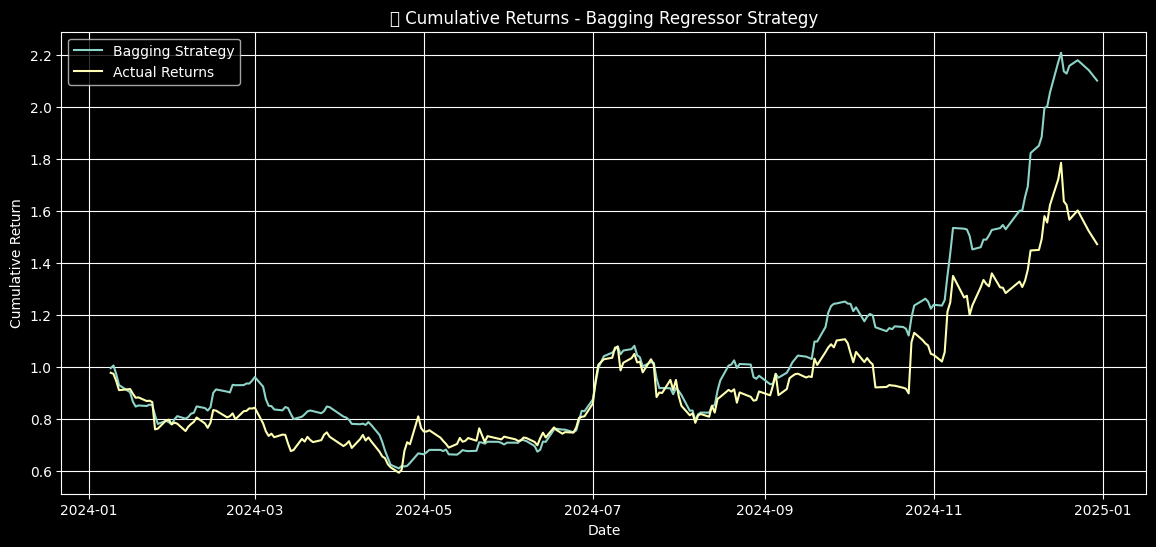

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


===== Bagging Regressor Strategy vs. Warren Buffett Performance Summary =====


Metric,Bagging Regressor Strategy,Warren Buffett (BRK-B),TSLA Buy & Hold
Total Return,-2.47%,21.97%,48.02%
Annual Return,-2.61%,23.41%,51.48%
Sharpe Ratio,0.27,1.50,0.97
Maximum Drawdown,-46.29%,-7.75%,-41.65%
Annual Volatility,62.74%,14.76%,62.63%
Final Balance,"$97,530.17","$121,973.23","$148,021.10"
Win Rate,48.32%,55.88%,51.68%


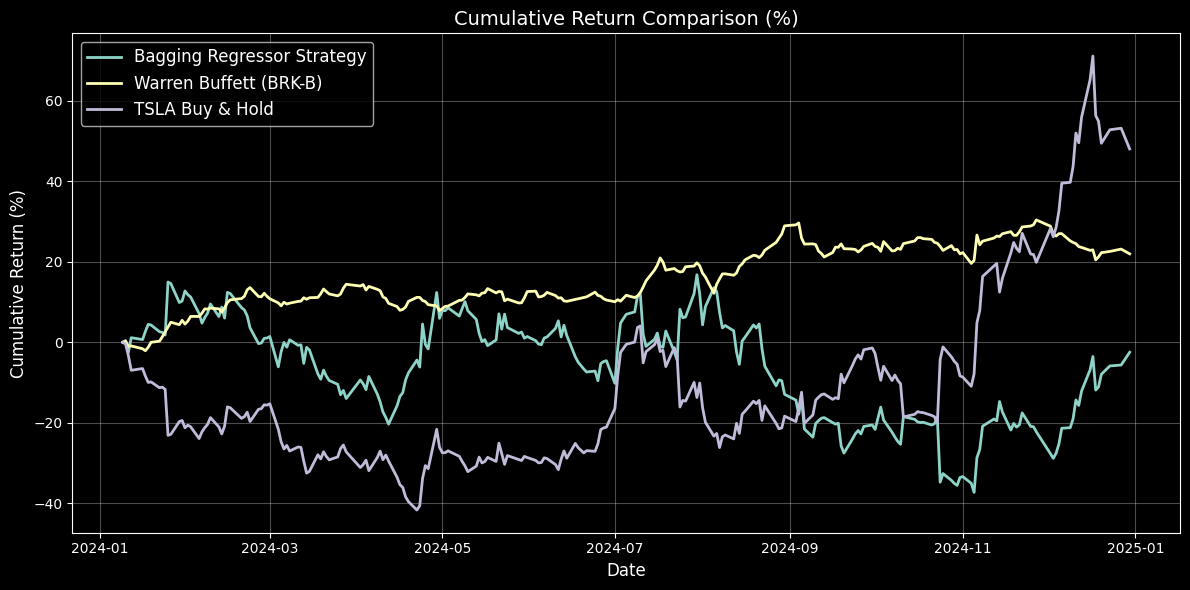

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

# Load CSV data
df = pd.read_csv("INFO6105_Final_TSLA_FeatureMart (1).csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Step 1: Feature Engineering
df['market_volatility'] = df['Mkt-RF'].rolling(20).std()
df['market_strength'] = df['Mkt-RF'].rolling(10).mean() / df['market_volatility']
df['log_volume'] = np.log1p(df['volume'])
df['volume_ma_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
df['rsi_trend'] = df['RSI_15'].rolling(5).mean() / df['RSI_15'].rolling(20).mean()
df['bb_position'] = (df['close'] - df['BBL_10_2.0']) / (df['BBU_10_2.0'] - df['BBL_10_2.0'])

for window in [5, 10, 15]:
    df[f'price_ma_ratio_{window}'] = df['close'] / df['close'].rolling(window).mean()
    df[f'volume_impact_{window}'] = (df['volume'] / df['volume'].rolling(window).mean()) * df['market_volatility']

df['quality_value'] = df['RMW'] * df['HML']
df['size_momentum'] = df['SMB'] * df['market_strength']

# Step 2: Select features and target
selected_features = [
    'RSI_15',              # Technical momentum indicator
    'MACD_5_20_9',         # Trend-following momentum
    'BBP_10_2.0',          # Bollinger Band % position
    'Mkt-RF', 'SMB', 'HML', 'RMW',  # Fama-French Factors
    'VIXCLS',              # Volatility Index (fear gauge)
    'SP500',               # Broad market movement
    'DGS10',               # Treasury yield (interest rate)
    'ADS_Index'            # Real economic activity index
]

y = df['Return_1D']
X = df[selected_features].copy()
X = X.fillna(method='ffill').fillna(method='bfill')
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# Step 3: Scale & Split
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Train Bagging Regressor
model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=50,
    max_samples=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Step 5: Evaluate
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
sharpe = np.mean(y_pred_test) / np.std(y_pred_test)
cum_returns = (1 + y_test).cumprod()
drawdown = cum_returns / cum_returns.cummax() - 1
max_drawdown = drawdown.min()

print("\n📊 Bagging Regressor Metrics:")
print(f"R² Test: {r2_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

# Step 6: Plot Cumulative Returns
plt.figure(figsize=(14, 6))
cum_strategy = (1 + pd.Series(y_pred_test, index=y_test.index)).cumprod()
plt.plot(y_test.index, cum_strategy, label='Bagging Strategy')
plt.plot(y_test.index, cum_returns, label='Actual Returns')
plt.title('📈 Cumulative Returns - Bagging Regressor Strategy')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Buffett Comparison (requires `compare_with_buffett()` to be defined)
bagging_comparison = compare_with_buffett(
    strategy_returns=pd.Series(y_pred_test, index=y_test.index),
    strategy_name="Bagging Regressor Strategy",
    initial_capital=100000,
    position_series=np.sign(y_pred_test)
)

Isolation Forest + Gradient Boosting Regressor

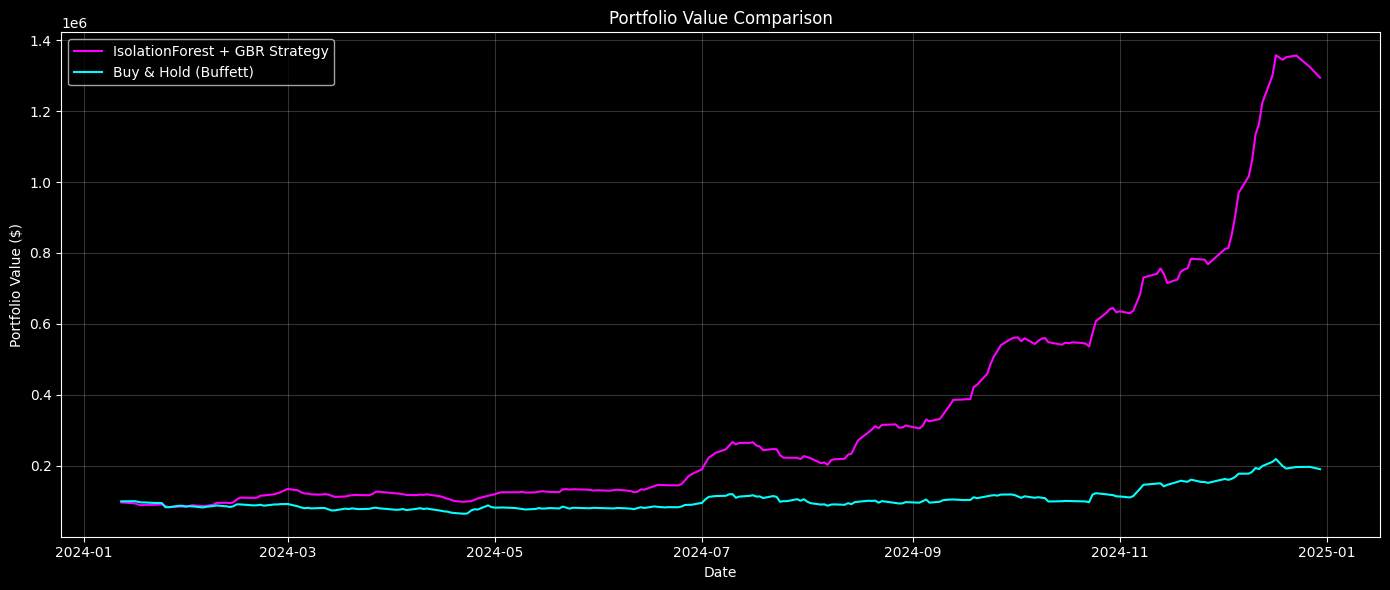

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


===== Isolation Forest + GBR Strategy vs. Warren Buffett Performance Summary =====


Metric,Isolation Forest + GBR Strategy,Warren Buffett (BRK-B),TSLA Buy & Hold
Total Return,-51.29%,23.22%,58.40%
Annual Return,-54.06%,25.33%,64.45%
Sharpe Ratio,-0.89,1.68,1.09
Maximum Drawdown,-66.11%,-7.75%,-37.59%
Annual Volatility,63.93%,14.02%,63.88%
Final Balance,"$48,713.58","$123,216.62","$158,400.01"
Win Rate,45.92%,55.79%,52.36%


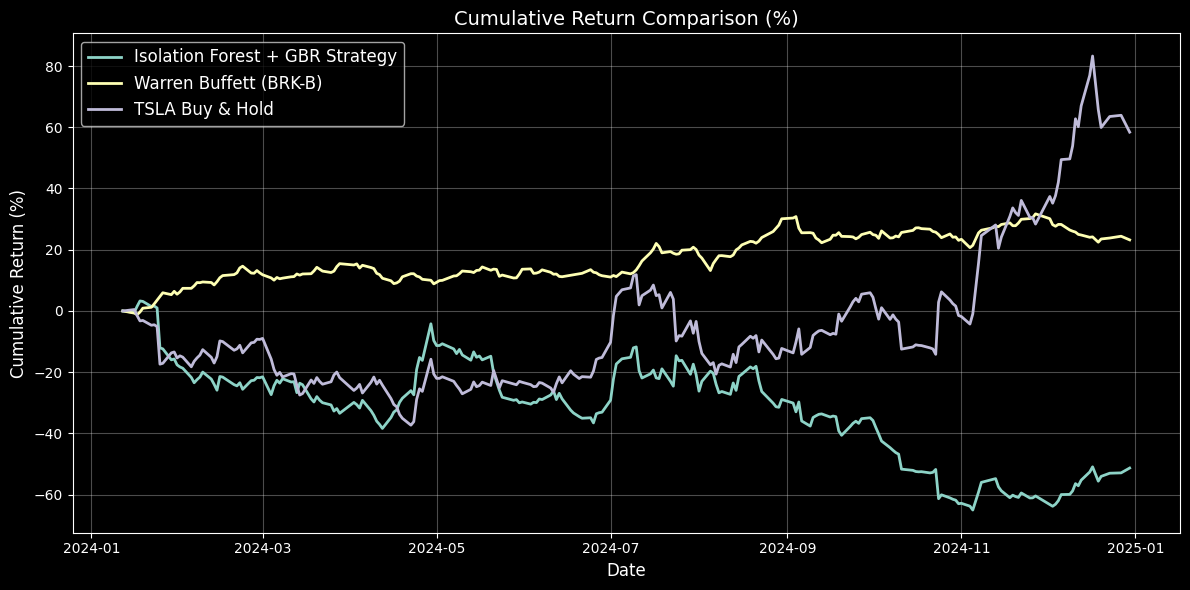

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# Step 1: Load Data
# -------------------------
df = pd.read_csv("INFO6105_Final_TSLA_FeatureMart (1).csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# -------------------------
# Step 2: Feature Selection
# -------------------------
selected_features = [
    # Technical indicators
    'RSI_15',               # Momentum indicator
    'MACD_5_20_9',          # Trend-following signal
    'BBP_10_2.0',           # Bollinger Band Position

    # Volatility & Macro
    'VIXCLS',               # Market volatility index
    'SP500',                # Broader equity index
    'DCOILWTICO',           # Oil price (WTI Crude) — macro commodity signal
    'DGS10',                # 10-Year Treasury yield (interest rate)
    'T10YIE',               # 10-Year inflation expectation

    # Crypto-related (cross-market sentiment)
    'CBBTCUSD',             # Bitcoin price
    'CBETHUSD',             # Ethereum price

    # Factor-based indicators
    'Mkt-RF', 'SMB', 'HML'  # Fama-French equity factors
]

# -------------------------
# Step 3: Prepare Features
# -------------------------
df = df.fillna(method='ffill').fillna(method='bfill')
def create_balanced_features(df):
    df['market_volatility'] = df['Mkt-RF'].rolling(20).std()
    df['market_strength'] = df['Mkt-RF'].rolling(10).mean() / df['market_volatility']
    
    df['log_volume'] = np.log1p(df['volume'])
    df['volume_ma_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
    
    df['rsi_trend'] = df['RSI_15'].rolling(5).mean() / df['RSI_15'].rolling(20).mean()
    df['bb_position'] = (df['close'] - df['BBL_10_2.0']) / (df['BBU_10_2.0'] - df['BBL_10_2.0'])
    
    for window in [5, 10, 15]:
        df[f'price_ma_ratio_{window}'] = df['close'] / df['close'].rolling(window).mean()
        df[f'volume_impact_{window}'] = (df['volume'] / df['volume'].rolling(window).mean()) * df['market_volatility']
    
    df['quality_value'] = df['RMW'] * df['HML']
    df['size_momentum'] = df['SMB'] * df['market_strength']
    
    return df

df = create_balanced_features(df)
X = df[selected_features].copy()
y = df['Return_1D']
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# -------------------------
# Step 4: Outlier Filtering (IsolationForest)
# -------------------------
iso = IsolationForest(contamination=0.02, random_state=42)
outlier_mask = iso.fit_predict(X) == 1
X_filtered = X[outlier_mask]
y_filtered = y[outlier_mask]

# -------------------------
# Step 5: Train/Test Split
# -------------------------
train_size = int(len(X_filtered) * 0.8)
X_train, X_test = X_filtered[:train_size], X_filtered[train_size:]
y_train, y_test = y_filtered[:train_size], y_filtered[train_size:]

# -------------------------
# Step 6: Gradient Boosting Regressor
# -------------------------
model = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
model.fit(X_train, y_train)
gbr_pred_test = model.predict(X_test)

# -------------------------
# Step 7: Performance Metrics
# -------------------------
returns = pd.Series(gbr_pred_test, index=y_test.index)

def calculate_sharpe(returns):
    excess = returns - 0  # Assuming risk-free rate is 0
    return np.mean(excess) / np.std(excess)

def calculate_max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

sharpe_ratio = calculate_sharpe(returns)
max_drawdown = calculate_max_drawdown(returns)
cum_strategy = (1 + returns).cumprod()
final_value = cum_strategy.iloc[-1] * 100000
# -------------------------
# Step 8: Visualization
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(cum_strategy.index, cum_strategy * 100000, label="IsolationForest + GBR Strategy", color='magenta')
buffett_price = df['close'].loc[cum_strategy.index]
buffett_cum = (1 + buffett_price.pct_change().fillna(0)).cumprod()
plt.plot(buffett_cum.index, buffett_cum * 100000, label="Buy & Hold (Buffett)", color='cyan')
plt.title("Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()
# -------------------------
# Step 9: Buffett Comparison
# -------------------------
isoforest_comparison = compare_with_buffett(
    strategy_returns=pd.Series(gbr_pred_test, index=y_test.index),
    strategy_name="Isolation Forest + GBR Strategy",
    initial_capital=100000,
    position_series=np.sign(gbr_pred_test)
)


Ridge Regression

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

📊 Ridge Regression Strategy Performance:
Sharpe Ratio: 0.1926
Max Drawdown: -40.54%
Final Portfolio Value: $293,509.45

===== Ridge Regression Strategy vs. Warren Buffett Performance Summary =====


Metric,Ridge Regression Strategy,Warren Buffett (BRK-B),TSLA Buy & Hold
Total Return,18.09%,21.97%,48.02%
Annual Return,19.25%,23.41%,51.48%
Sharpe Ratio,0.59,1.50,0.97
Maximum Drawdown,-53.98%,-7.75%,-41.65%
Annual Volatility,62.70%,14.76%,62.63%
Final Balance,"$118,093.49","$121,973.23","$148,021.10"
Win Rate,47.90%,55.88%,51.68%


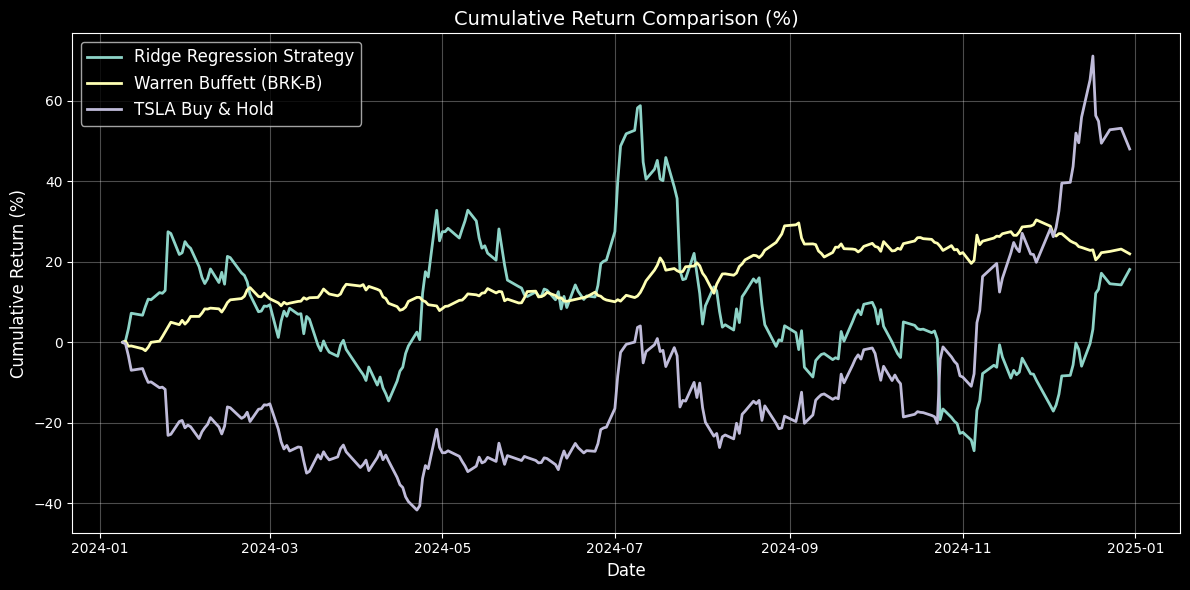

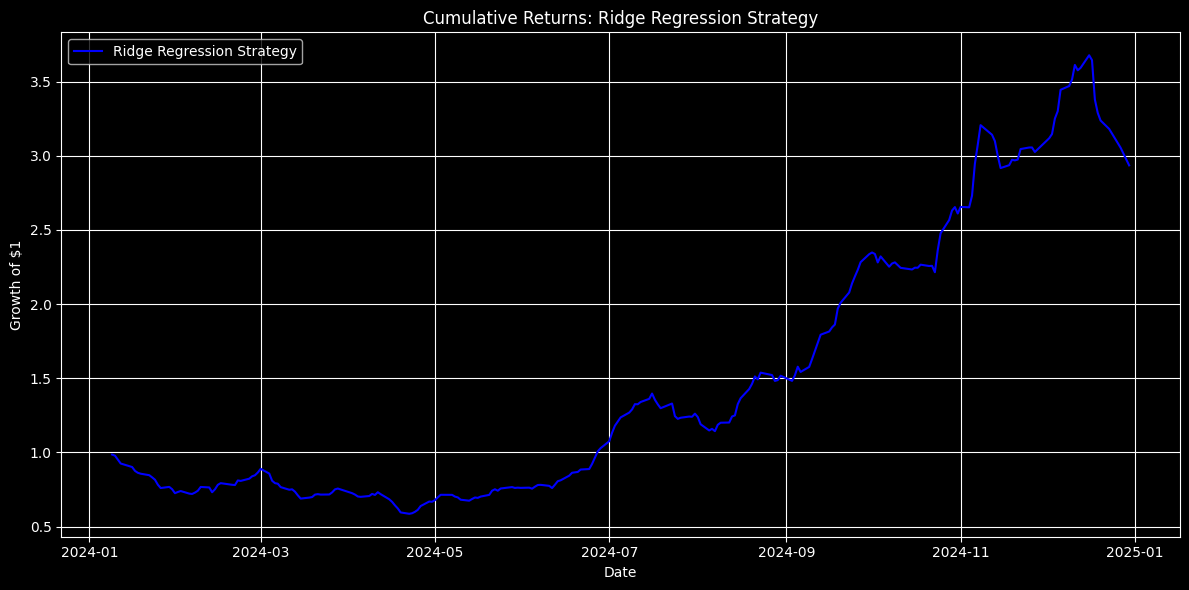

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# --- Utility Functions ---

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# --- Load Your Data ---

df = pd.read_csv("INFO6105_Final_TSLA_FeatureMart (1).csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# --- Feature Selection ---

selected_features = [
    'RSI_15',              # Relative Strength Index (momentum)
    'MACD_5_20_9',         # MACD signal (momentum)
    'BBP_10_2.0',          # Bollinger Band Position (volatility)
    'Mkt-RF',              # Market risk premium
    'SMB', 'HML', 'RMW', 'CMA',  # Fama-French factors
    'VIXCLS',              # Volatility Index
    'SP500',               # Market index
    'DGS10'                # Interest rate (10Y Treasury)
]
# --- Prepare Data ---

df = df.fillna(method='ffill').fillna(method='bfill')
X = df[selected_features].copy()
y = df['Return_1D']
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# --- Train Ridge Regression ---

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
returns_series = pd.Series(y_pred_test, index=y_test.index)

# --- Metrics ---

cum_returns = (1 + returns_series).cumprod()
sharpe = sharpe_ratio(returns_series)
drawdown = max_drawdown(cum_returns)
final_value = cum_returns.iloc[-1] * 100000

print("📊 Ridge Regression Strategy Performance:")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Max Drawdown: {drawdown:.2%}")
print(f"Final Portfolio Value: ${final_value:,.2f}")

# --- Buffett Comparison ---

ridge_comparison = compare_with_buffett(
    strategy_returns=returns_series,
    strategy_name="Ridge Regression Strategy",
    initial_capital=100000,
    position_series=np.sign(y_pred_test)
)
# --- Plot Cumulative Returns ---

plt.figure(figsize=(12, 6))
plt.plot(cum_returns, label='Ridge Regression Strategy', color='blue')
plt.title("Cumulative Returns: Ridge Regression Strategy")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Decision Tree Regressor

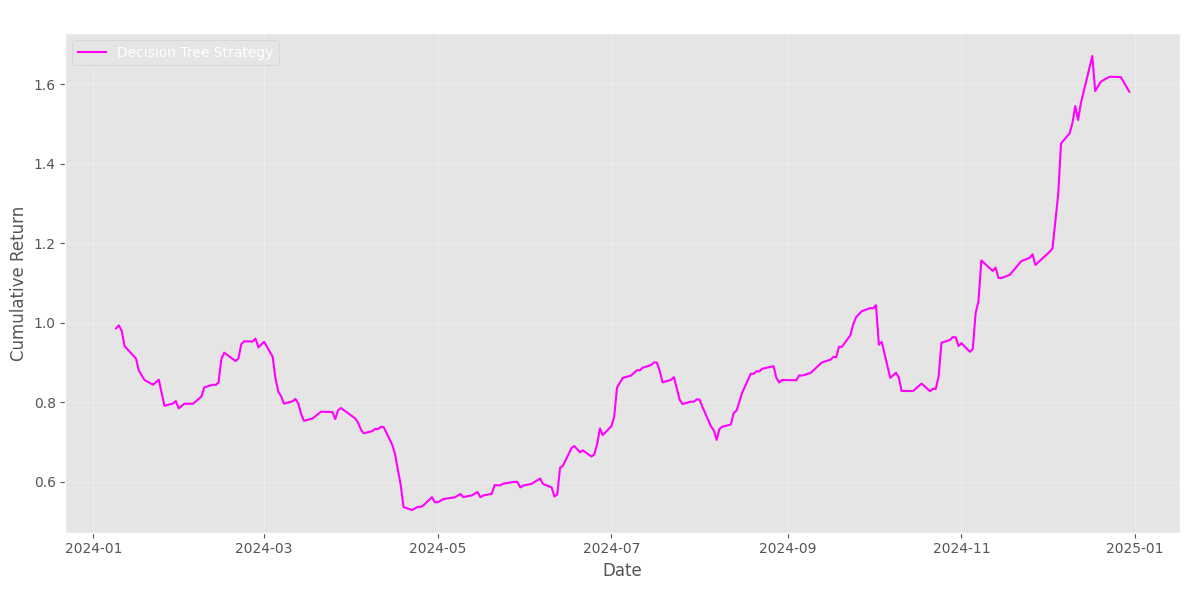

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


===== Decision Tree Regressor Strategy vs. Warren Buffett Performance Summary =====


Metric,Decision Tree Regressor Strategy,Warren Buffett (BRK-B),TSLA Buy & Hold
Total Return,-65.28%,21.97%,48.02%
Annual Return,-67.38%,23.41%,51.48%
Sharpe Ratio,-1.47,1.50,0.97
Maximum Drawdown,-72.08%,-7.75%,-41.65%
Annual Volatility,62.48%,14.76%,62.63%
Final Balance,"$34,715.10","$121,973.23","$148,021.10"
Win Rate,41.60%,55.88%,51.68%


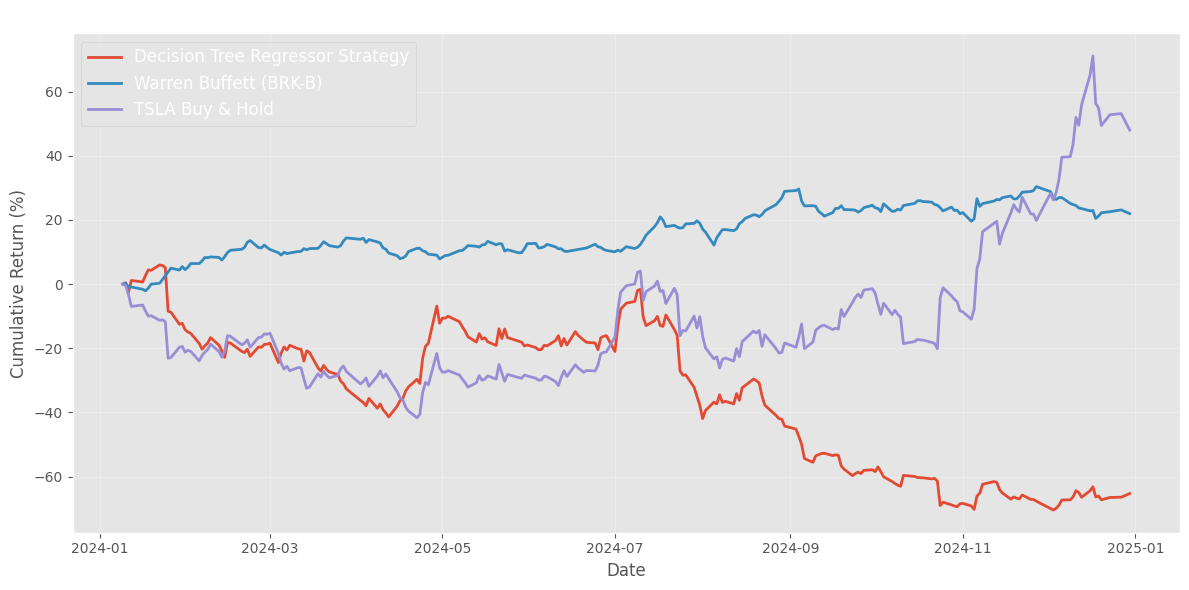

In [15]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# Step 1: Load and prepare data
# -----------------------------
df = pd.read_csv("INFO6105_Final_TSLA_FeatureMart (1).csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select refined features
selected_features = [
    'RSI_15', 'MACD_5_20_9', 'BBP_10_2.0',  # Technical Indicators
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA',   # Fama-French factors
    'VIXCLS', 'SP500', 'DGS10'             # Market & macro
]

# -------------------------
# Step 2: Feature Prep
# -------------------------
df = df.fillna(method='ffill').fillna(method='bfill')
X = df[selected_features].copy()
y = df['Return_1D']
mask = ~(X.isna().any(axis=1) | y.isna())
X, y = X[mask], y[mask]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# -------------------------
# Step 3: Split data
# -------------------------
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# -------------------------
# Step 4: Train Model
# -------------------------
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# -------------------------
# Step 5: Metrics
# -------------------------
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Sharpe Ratio
returns = pd.Series(y_pred_test, index=y_test.index)
sharpe = np.mean(returns) / np.std(returns)

# Max Drawdown
cum_returns = (1 + returns).cumprod()
peak = cum_returns.cummax()
drawdown = (cum_returns - peak) / peak
max_drawdown = drawdown.min()

# -------------------------
# Step 6: Plot Returns (Fixed)
# -------------------------
plt.style.use("ggplot")  # Safe default; or comment out
plt.figure(figsize=(12, 6))
plt.plot(cum_returns, label="Decision Tree Strategy", color='magenta')
plt.title("Cumulative Returns - Decision Tree Regressor")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Step 7: Buffett Comparison
# -------------------------
# Define or ensure compare_with_buffett() is available in notebook
dtr_comparison = compare_with_buffett(
    strategy_returns=pd.Series(y_pred_test, index=y_test.index),
    strategy_name="Decision Tree Regressor Strategy",
    initial_capital=100000,
    position_series=np.sign(y_pred_test)
)
